# Testing with Toy Data

This notebook was written to summarise the tests done on two toy functions, one linear and the other non-linear. These functions had a one dimensional output, and a two dimensional input, and were devised as simplified system models; that is the inputs are the current state and action to be taken, and the output is the resultant state. This notebook follows the blog post [here](add line here). 

Furthermore, most of the back-end code is found [here](add link here) in the gympy.py source file. For the most part this code presently prepares the appropriate components required to carry  out reinforcement learning, under the class *rl_components*.

In [ ]:
import gympy as gp
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
%matplotlib inline

To begin with, the linear model was tested. This was defined as:

$$s_{t+1} = 10a_t + s_t$$

This was tested with two definitions of the action policy. The following section details the results found by defining the policy as being linear. That is:

$$a_t = \theta_1a_t + \theta_0$$
where $\theta_i$ are the policy parameters.

## Linear system; linear policy

The class *rl_components* allows the user to defined the model, the policy, reward function and termination criteria. Presently, the class assumes that the model, policy and the reward function have standard forms defined as:

$$s_{t+1} = f(s_t,a_t)$$
$$a_t = g(\theta_i,s_t)$$
$$r_t = h(s_t, s_T)$$

where s_T is the termination or goal state. 

In order to remain as flexible as possible, the function that returns the termination condition is to be defined as a class, which inherits all the properties of the current program instant. These properties include a wide variety of standard measurements; they can be found in the source file. 

In [2]:
def f(action, current_state):
    current_state = 10*((action)) + current_state
    
    return current_state

In [3]:
def action_from_policy(policyParameters, current_state):
    action = 0
    [r,c] = policyParameters.shape
    for i in range(c):
        if i < c-1:
            action = action + (policyParameters[0,i]*current_state[0,i])
        else:
            action = action + policyParameters[0,i]
    
    action = np.pi * ((9/8)*np.sin(action) + (1/8)*np.sin(3*action))
    
    return np.reshape(np.array([action]), ([1,1]))  

In [4]:
def reward_function(current_states, goal_states):
    buffer_reward = abs(goal_states - current_states)
    return buffer_reward

In [35]:
class termination_function:
    def __init__(self, inheritence):
        self.inheritence = inheritence
        self.terminate = None
        self.goal_limit = 30
    def check(self):
        if self.inheritence.current_reward[0,0] < 10:
            self.inheritence.goal_counter += 1
        if self.inheritence.goal_counter >= self.goal_limit or self.inheritence.total_counter >=300:
            self.terminate = True
        else: 
            self.terminate = False
        
        self.inheritence.total_counter += 1
        
        return self.terminate

In [6]:
goal_states = np.array([[100]])
initial_states = np.array([[0]])
linear_RL = gp.rl_components(dimensions_input=2,dimensions_output=1,model_simulator=f, action_from_policy=action_from_policy, reward_function=reward_function, termination_function=termination_function, goal_states=goal_states, initial_states=initial_states)

The following subsection was used to test the fundamental functioning of the source code. It uses 50 training points to train a GP, which is then used with Expected Improvement to find an optimal policy that achieves the conditions of the previously defined termination function.

Think of it as a proof of concept. 

In [7]:
linear_RL.generate_training_data_random(iterations=50,action_min=-np.pi,action_max=np.pi,action_dim=1)

50 training data gathered


In [8]:
k1 = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)
k2 = GPy.kern.Linear(input_dim=2)

The following two plots show the differences between the choice a RBF kernel and a Linear kernal respectively, for the initialisation of the GP. As can be seen, the linear kernal appears to be better suited for this particular example. 

Perhaps this is to be expected considering that the system is linear. 

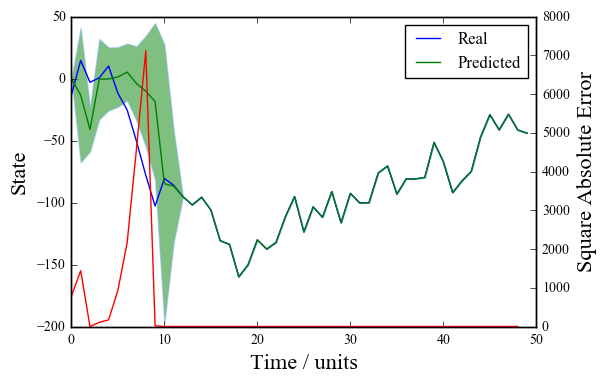

In [11]:
plot_counter = 0
plotter = gp.plot(linear_RL)
plotter.plot_counter = plot_counter
plotter.predicted_path_GP(k1)
plot_counter += 1

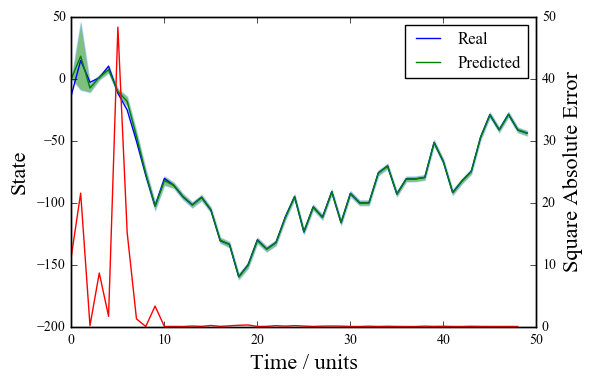

In [12]:
plotter2 = gp.plot(linear_RL)
plotter2.plot_counter = plot_counter
plotter2.predicted_path_GP(k2)
plot_counter += 1

In [13]:
linear_RL.model = GPy.models.GPRegression(linear_RL.train_inputs, linear_RL.train_outputs, k2)

In [14]:
bounds = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-10,10), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1}]

In [15]:
linear_RL.progress_counter = 0
linear_RL.progress_print = False
myBopt = GPyOpt.methods.BayesianOptimization(f = linear_RL.objective_function, domain = bounds, acquisition_type ='EI', num_cores=4, verbosity=True)
max_iter = 150              # evaluation budget
myBopt.run_optimization(max_iter) 

In [16]:
linear_RL.policy_parameters = myBopt.X[np.argmin(myBopt.Y)]
linear_RL.policy_parameters = np.reshape(linear_RL.policy_parameters, ([1,2]))
print linear_RL.policy_parameters, np.argmin(myBopt.Y)

[[-0.01644644  1.53499933]] 15


[[-0.01644644  1.53499933]]


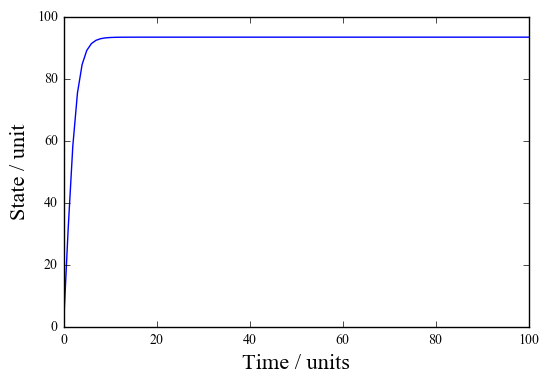

In [17]:
plotter3 = gp.plot(linear_RL)
plotter3.plot_counter = plot_counter
plotter3.run_simulation_true(iterations = 100)
plot_counter += 1

As can be seen above, the program reaches the goal of maintaining the final state between 110 and 90, as defined by the termination criteria; that is within 10% of the goal state of 100.

Below, is an example of a particular test that generated a policy that  matched the required goal within to approximately 1%.

[[-0.02163114  8.44695543]]


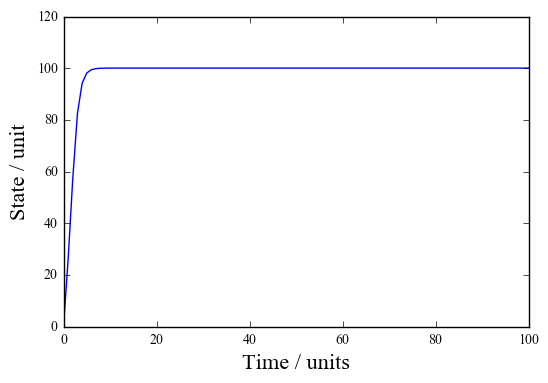

In [35]:
plotter3 = gp.plot(linear_RL)
plotter3.run_simulation_true(iterations = 100)

The subsection below deals with a true RL program. The GP is trained with a small number of data points. This is then used to find a good policy, which is then used on the real system to gain new training points. This loop is carried out until the agent is sufficient in its task. 

Note that in this particular program, only 3 loops of this iterative process is carried out. 

In [18]:
linear_RL.train_inputs = None
linear_RL.train_outputs = None
linear_RL.generate_training_data_random(iterations=10,action_min=-np.pi,action_max=np.pi,action_dim=1)
linear_RL.model = GPy.models.GPRegression(linear_RL.train_inputs, linear_RL.train_outputs, k2)
print linear_RL.train_outputs.shape

10 training data gathered
(10, 1)


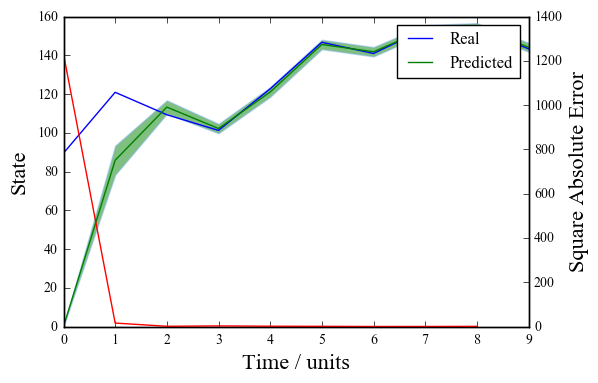

In [20]:
plotter4 = gp.plot(linear_RL)
plotter4.plot_counter = plot_counter
plotter4.predicted_path_GP(k2)
plot_counter += 1

In [21]:

linear_RL.progress_print = True

from IPython.display import clear_output

for i in range(3):
    print i
    linear_RL.progress_counter = 0
    
    myBopt = GPyOpt.methods.BayesianOptimization(f = linear_RL.objective_function, domain = bounds, acquisition_type ='EI', num_cores=4, verbosity=True)
    max_iter = 150              # evaluation budget
    myBopt.run_optimization(max_iter) 
    
    linear_RL.policy_parameters = myBopt.X[np.argmin(myBopt.Y)]
    linear_RL.policy_parameters = np.reshape(linear_RL.policy_parameters, ([1,2]))
    
    linear_RL.generate_training_data_continuous(100)
    print linear_RL.train_outputs.shape, linear_RL.train_inputs.shape
    
    linear_RL.model = GPy.models.GPRegression(linear_RL.train_inputs, linear_RL.train_outputs, k2)
    if linear_RL.model.name != 'linear':
        linear_RL.model.optimize()
    
    clear_output()
    
    

Once again, the agent is within 10% of the goal state. 

40
[[-0.01029351  0.92497387]]


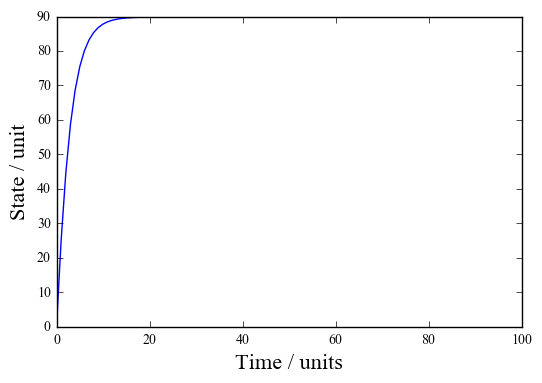

In [22]:
print np.argmin(myBopt.Y)
plotter5 = gp.plot(linear_RL)
plotter5.plot_counter = plot_counter
plotter5.run_simulation_true(iterations = 100)
plot_counter += 1

4
[[ 0.0315671   0.36117921]]


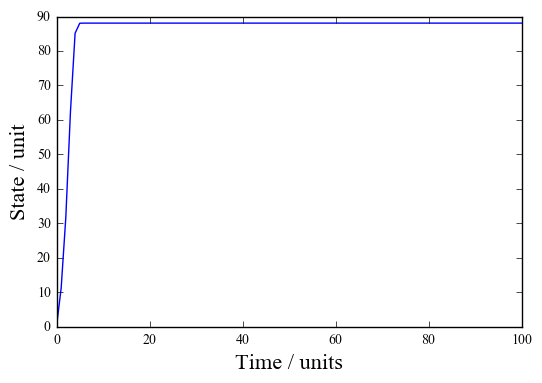

In [68]:
print np.argmin(myBopt.Y)
plotter5 = gp.plot(linear_RL)
plotter5.run_simulation_true(iterations = 100)

In [26]:
linear_RL.train_outputs.shape

(11, 2)

## Linear System; Non-Linear Policy

In this, the only change that is made is that the policy is now defined as a network of RBF nodes. 

That is, it is given by:

$$ a_t = \sum^{3}_{n=1} \theta_0e^{\frac{-(s_t - \theta_1)^2}{\theta_2^2}}$$

Since there are 3 nodes, there are 9 total parameters. 

In [69]:
def policy_rbf(policy_parameters, current_state):
    num_para = 3
    action = 0
    [r,c] = policy_parameters.shape
    n = c / num_para
    
    for node in range(n):
        action = np.pi*policy_parameters[0,node*num_para]*np.exp(-1*((current_state[0,0]-policy_parameters[0,1+node*num_para])*(current_state[0,0]-policy_parameters[0,1+node*num_para]))/((policy_parameters[0,2+node*num_para])*(policy_parameters[0,2+node*num_para])))     
    
    return np.reshape(np.array([action]), ([1,1]))

class termination_function:
    def __init__(self, inheritence):
        self.inheritence = inheritence
        self.terminate = None
        self.goal_limit = 50
    def check(self):
        if self.inheritence.current_reward[0,0] < 10:
            self.inheritence.goal_counter += 1
        if self.inheritence.goal_counter >= self.goal_limit or self.inheritence.total_counter >=500:
            self.terminate = True
        else: 
            self.terminate = False
        
        self.inheritence.total_counter += 1
        
        return self.terminate

In [70]:
linear_RBF = gp.rl_components(dimensions_input=2,dimensions_output=1,model_simulator=f, action_from_policy=policy_rbf, reward_function=reward_function, termination_function=termination_function, goal_states=goal_states, initial_states=initial_states)

In [71]:
linear_RBF.train_inputs = None
linear_RBF.train_outputs = None
linear_RBF.generate_training_data_random(iterations=10,action_min=-np.pi,action_max=np.pi,action_dim=1)
linear_RBF.model = GPy.models.GPRegression(linear_RBF.train_inputs, linear_RBF.train_outputs, k2)
print linear_RBF.train_outputs.shape

10 training data gathered
(10, 1)


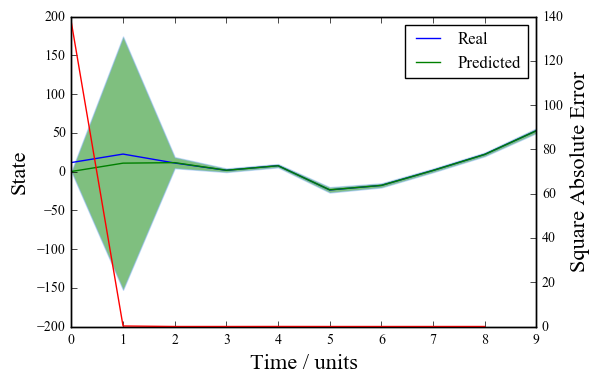

In [72]:
plotter6 = gp.plot(linear_RBF)
plotter6.plot_counter = plot_counter
plotter6.predicted_path_GP(k2)
plot_counter += 1

Note that the limits of each of the parameters were chosen so that sufficiently substantial actions can be obtained at the range of expected states. 

In [73]:
bounds_2 = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_2', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_3', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_5', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_6', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_7', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-50,50), 'name': 'var_8', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,100), 'name': 'var_9', 'type': 'continuous', 'dimensionality':1}]
          

In [74]:

linear_RBF.progress_print = True
from IPython.display import clear_output

for i in range(5):
    print i
    linear_RBF.progress_counter = 0
    
    myBopt2 = GPyOpt.methods.BayesianOptimization(f = linear_RBF.objective_function, domain = bounds_2, acquisition_type ='EI', num_cores=4, verbosity=True)
    max_iter = 150              # evaluation budget
    myBopt2.run_optimization(max_iter) 
    
    linear_RBF.policy_parameters = myBopt2.X[np.argmin(myBopt2.Y)]
    linear_RBF.policy_parameters = np.reshape(linear_RBF.policy_parameters, ([1,9]))
    
    linear_RBF.generate_training_data_continuous(100)
    print linear_RBF.train_outputs.shape, linear_RBF.train_inputs.shape
    
    linear_RBF.model = GPy.models.GPRegression(linear_RBF.train_inputs, linear_RBF.train_outputs, k2)
    if linear_RBF.model.name != 'linear':
        linear_RBF.model.optimize()
    
    clear_output()

2
[[  0.46938856 -31.46041651  39.71528656  -0.12659301  46.82968752
   51.57128037   0.91540114 -19.82172782  54.68562814]]


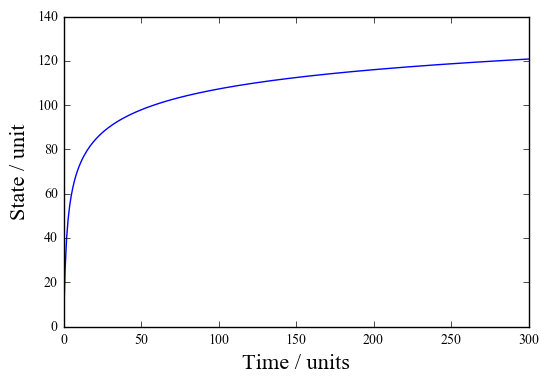

In [75]:
linear_RBF.policy_parameters = myBopt2.X[np.argmin(myBopt2.Y)]
print np.argmin(myBopt2.Y)
linear_RBF.policy_parameters = np.reshape(linear_RBF.policy_parameters, ([1,9]))
plotter7 = gp.plot(linear_RBF)
plotter7.plot_counter = plot_counter
plotter7.run_simulation_true(300)
plot_counter += 1

## Non-linear System; Linear Policy

In [171]:
def f_nl(action, current_states):
    current_states = 20*(np.sin(action)) + current_states
    
    return current_states

def policy_rbf(policy_parameters, current_state):
    num_para = 3
    action = 0
    [r,c] = policy_parameters.shape
    n = c / num_para
    
    for node in range(n):
        action = np.pi*policy_parameters[0,node*num_para]*np.exp(-1*((current_state[0,0]-policy_parameters[0,1+node*num_para])*(current_state[0,0]-policy_parameters[0,1+node*num_para]))/((policy_parameters[0,2+node*num_para])*(policy_parameters[0,2+node*num_para])))     
    
    return np.reshape(np.array([action]), ([1,1]))

def reward_function_nl(current_states, goal_states):
    buffer_reward = abs(goal_states - current_states)
    if buffer_reward > 10:
        buffer_reward = buffer_reward * 10 
    return buffer_reward

In [172]:
nlinear_lin = gp.rl_components(dimensions_input=2,dimensions_output=1,model_simulator=f_nl, action_from_policy=policy_rbf, reward_function=reward_function_nl, termination_function=termination_function, goal_states=goal_states, initial_states=initial_states)

In [173]:
nlinear_lin.train_inputs = None
nlinear_lin.train_outputs = None
nlinear_lin.generate_training_data_random(iterations=100,action_min=-np.pi,action_max=np.pi,action_dim=1)
nlinear_lin.model = GPy.models.GPRegression(nlinear_lin.train_inputs, nlinear_lin.train_outputs, k1)
nlinear_lin.model.optimize()
print nlinear_lin.train_outputs.shape

100 training data gathered
(100, 1)


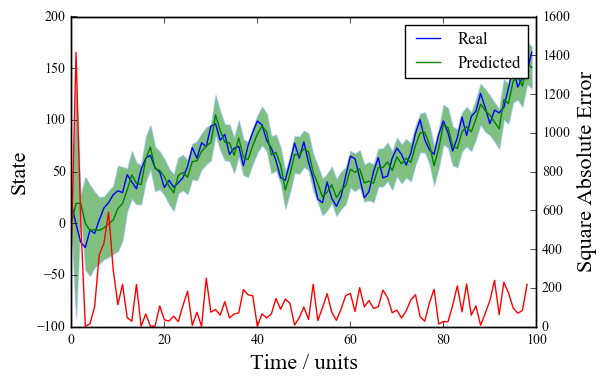

In [174]:
plotter8 = gp.plot(nlinear_lin)
plotter8.plot_counter = plot_counter
plotter8.predicted_path_GP(k1)
plot_counter += 1

In [175]:
bounds_4 = [{'domain': (-1,100), 'name': 'var_1', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-200,200), 'name': 'var_2', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,200), 'name': 'var_3', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-200,200), 'name': 'var_5', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,200), 'name': 'var_6', 'type': 'continuous', 'dimensionality':1},
          {'domain': (-1,1), 'name': 'var_7', 'type': 'continuous', 'dimensionality':1},
         {'domain': (-200,200), 'name': 'var_8', 'type': 'continuous', 'dimensionality':1},
          {'domain': (0,200), 'name': 'var_9', 'type': 'continuous', 'dimensionality':1}]
          

In [176]:
myBopt4 = GPyOpt.methods.BayesianOptimization(f = nlinear_lin.objective_function, domain = bounds_4, acquisition_type ='EI', num_cores=4, verbosity=True)
max_iter = 150              # evaluation budget
myBopt4.run_optimization(max_iter) 

In [177]:

nlinear_lin.progress_print = True
train_GP = True
from IPython.display import clear_output

for i in range(10):
    print i
    nlinear_lin.progress_counter = 0
    
    myBopt3 = GPyOpt.methods.BayesianOptimization(f = nlinear_lin.objective_function, domain = bounds_4, acquisition_type ='EI', num_cores=1, verbosity=True)
    max_iter = 150              # evaluation budget
    myBopt3.run_optimization(max_iter) 
    
    nlinear_lin.policy_parameters = myBopt3.X[np.argmin(myBopt3.Y)]
    nlinear_lin.policy_parameters = np.reshape(nlinear_lin.policy_parameters, ([1,9]))
    print nlinear_lin.policy_parameters, '\t', np.argmin(myBopt3.Y)
    
    nlinear_lin.generate_training_data_continuous(150)
    print nlinear_lin.train_outputs.shape, nlinear_lin.train_inputs.shape
    
    if train_GP == True:
        nlinear_lin.model = GPy.models.GPRegression(nlinear_lin.train_inputs, nlinear_lin.train_outputs, k1)
        if nlinear_lin.model.name != 'linear':
            nlinear_lin.model.optimize()
        
    #clear_output()

0
50 	102 	1 	[[ 8.33865356]]
0 	501 	2 	[[ 203.76388602]]
0 	501 	3 	[[ 201.43825635]]
1 	501 	4 	[[ 492.93999925]]
0 	501 	5 	[[ 203.7638507]]
0 	501 	6 	[[ 203.7638507]]
1 	501 	7 	[[ 1610.47471806]]
0 	501 	8 	[[ 205.30703492]]
0 	501 	9 	[[ 203.7638507]]
50 	166 	10 	[[ 8.59559283]]
0 	501 	11 	[[ 1411.29668266]]
50 	110 	12 	[[ 5.40879413]]
0 	501 	13 	[[ 100.76322332]]
0 	501 	14 	[[ 123.94178845]]
0 	501 	15 	[[ 121.62510209]]
2 	501 	16 	[[ 753.1586048]]
0 	501 	17 	[[ 216.87381014]]
0 	501 	18 	[[ 1207.31663659]]
0 	501 	19 	[[ 316.023729]]
0 	501 	20 	[[ 2391.36284187]]
0 	501 	21 	[[ 153.93224359]]
0 	501 	22 	[[ 203.7908151]]
0 	501 	23 	[[ 203.7638507]]
0 	501 	24 	[[ 1019.55058254]]
0 	501 	25 	[[ 1784.34581175]]
3 	501 	26 	[[ 756.17476434]]
0 	501 	27 	[[ 2147.04173356]]
0 	501 	28 	[[ 644.17470351]]
0 	501 	29 	[[ 879.83646519]]
0 	501 	30 	[[ 209.44837093]]
0 	501 	31 	[[ 1766.36216417]]
0 	501 	32 	[[ 1491.96145445]]
15 	501 	33 	[[ 383.10721375]]
0 	501 	34 	[[ 244

[[  74.42896389  182.89917237   23.72937569   -0.53831323   48.36609935
    68.23071423    0.55238848   51.93395169   24.69520467]]


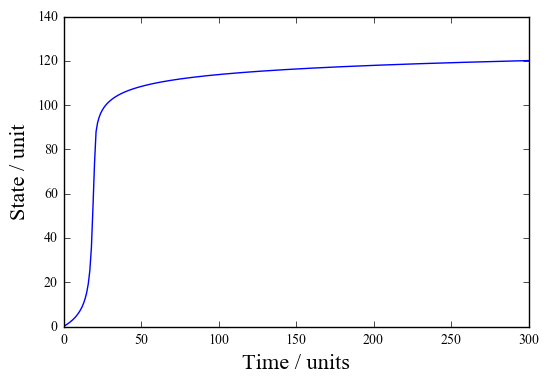

In [178]:
nlinear_lin.policy_parameters = myBopt3.X[np.argmin(myBopt3.Y)]
nlinear_lin.policy_parameters = np.reshape(nlinear_lin.policy_parameters, ([1,9]))
plotter10 = gp.plot(nlinear_lin) 
#plotter10.inheritence.policy_parameters = np.array([9.84039382e+00,  -1.24897377e+01,   1.60255619e+02,   9.98394145e-01,
    #6.17006455e+01,  1.25011171e+02,  -1.07269920e-01,   1.19315400e+02,
    #1.29356015e+01])
#plotter10.inheritence.policy_parameters = np.reshape(plotter10.inheritence.policy_parameters, ([1,9]))
plotter10.plot_counter = plot_counter
plotter10.run_simulation_true(300)
plot_counter += 1